In [1]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Dropout2d
from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import os

# PART 1. CNN Model

### Step 1. Load data

In [2]:
def get_images_array(imageFile, dataPath):
    with open(imageFile, "r") as f:
        images =  []
        labels = []
        for image in f:
            image =image.replace("\n", "")
            if 'NonCOVID' in imageFile:
                image = imread(dataPath + '/CT_NonCOVID/' + image, as_gray=True)
                image = resize(image, [200, 200])
                image = image.astype('float32')
                image /= 255
                images.append(image)
                labels.append(0)
            else:
                image = imread(dataPath + '/CT_COVID/' + image, as_gray=True)
                image = resize(image, [200, 200])
                image = image.astype('float32')
                image /= 255
                images.append(image)
                labels.append(1)
        return images,labels
            

In [3]:
base_dir= '../../../data'
train_im, train_labels = get_images_array(base_dir+'/Data-split/COVID/trainCT_COVID.txt', base_dir)
train_imNC, train_labels_nc = get_images_array(base_dir+'/Data-split/NonCOVID/trainCT_NonCOVID.txt', base_dir)
train_im.extend(train_imNC)
train_labels.extend(train_labels_nc)

train_features = np.array(train_im)
train_labels = np.int64(np.array(train_labels))

test_im, test_labels = get_images_array(base_dir+'/Data-split/COVID/testCT_COVID.txt', base_dir)
test_im_nc, test_labels_nc = get_images_array(base_dir+'/Data-split/NonCOVID/testCT_NonCOVID.txt', base_dir)
test_im.extend(test_im_nc)
test_labels.extend(test_labels_nc)

test_features = np.array(test_im)
test_labels = np.int64(np.array(test_labels))

print(train_features.shape)

(425, 200, 200)


### Step 2. Visualize data

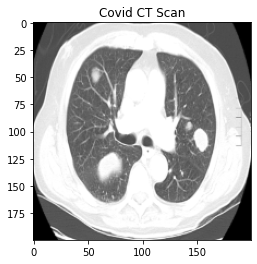

In [4]:
## covid ct scan
index = np.argmin(train_labels)
plt.title("Covid CT Scan")
plt.imshow(train_im[index], 'gray')
assert(np.min(train_labels) == 0)

plt.show()

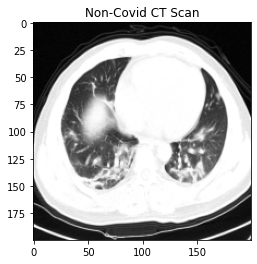

In [5]:
## non-covid ct scan
index = np.argmax(train_labels)
plt.title("Non-Covid CT Scan")
plt.imshow(train_im[index], 'gray')
assert(np.max(train_labels) == 1)
plt.show()

### Step 3. Split data into training, validation, and test sets

In [6]:
train_x, val_x, train_y, val_y = train_test_split(train_features, train_labels, test_size = 0.05)

train_x = train_x.reshape(403, 1, 200, 200)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
val_x = val_x.reshape(22, 1, 200, 200)
val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

test_features = test_features.reshape(203, 1, 200, 200)
test_x = torch.from_numpy(test_features)
test_y = torch.from_numpy(test_labels)

print("Training set shape:", train_x.shape)
print("Test set shape:", test_x.shape)
print("Validation set shape:", val_x.shape)

Training set shape: torch.Size([403, 1, 200, 200])
Test set shape: torch.Size([203, 1, 200, 200])
Validation set shape: torch.Size([22, 1, 200, 200])


### Step 4. Build CNN model

In [7]:
class CNN(Module):   
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 10, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(10),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(10, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(10000, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [8]:
model = CNN()
#Load model
# model.load_state_dict(torch.load("../../models/covid_cnn.pth"))

In [9]:
print(model)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# if torch.cuda.is_available():
#     model = model.cuda()
#     criterion = criterion.cuda()

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=10000, out_features=2, bias=True)
  )
)


### Step 5. Train model

In [10]:
def train_cnn():
    model.train()
    loss = 0
    trainx = Variable(train_x)
    trainy = Variable(train_y)
    valx = Variable(val_x)
    valy = Variable(val_y)
   
    optimizer.zero_grad()
    train_out = model(trainx)
    val_out = model(valx)
    train_loss = criterion(train_out, trainy)
    val_loss = criterion(val_out, valy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    train_loss.backward()
    optimizer.step()
    loss = train_loss.item()
    print('Epoch : ',epoch+1, '\t', 'loss :', val_loss.item())
    return val_loss

In [17]:
n_epochs = 30
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_cnn()

Epoch :  1 	 loss : 0.5689396858215332
Epoch :  2 	 loss : 0.5722491145133972
Epoch :  3 	 loss : 0.5748518705368042
Epoch :  4 	 loss : 0.5763611197471619
Epoch :  5 	 loss : 0.5764987468719482
Epoch :  6 	 loss : 0.5752263069152832
Epoch :  7 	 loss : 0.5727980136871338
Epoch :  8 	 loss : 0.5696117877960205
Epoch :  9 	 loss : 0.5660719275474548
Epoch :  10 	 loss : 0.5625238418579102


### Step 6. Data visualization

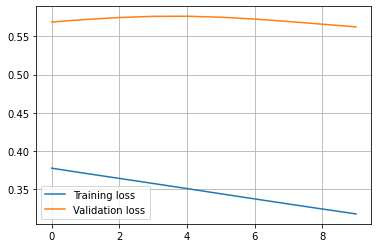

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.grid()
plt.show()

In [19]:
def accuracy(features, labels):
    with torch.no_grad():
        output = model(features)
    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    return accuracy_score(labels, predictions)

In [20]:
# accuracy on training set
print("Train ACCURACY", accuracy(train_x, train_y))

Train ACCURACY 0.8684863523573201


In [21]:
# accuracy on validation set
print("Validation accuracy", accuracy(val_x, val_y))

Validation accuracy 0.7272727272727273


In [22]:
# accuracy on test set
print("Test accuracy", accuracy(test_x, test_y))

Test accuracy 0.6206896551724138


In [23]:
#Read more: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), "../../models/covid_cnn.pth")

# Part 2: Conformal Prediction

In [18]:
def euclid(point, centroid):
    """Calculate the distance between a test point and a centroid point"""
    #assuming point and centroid are tensors
    point = np.array(point.tolist())
    centroid = np.array(centroid.tolist())
    return np.linalg.norm(point - centroid)

In [19]:
def centroid(data):
    """Find the centroid for one class of object"""
    #print(data.shape)
    features, observations = data.shape
    if(features > observations):
        raise ValueError("too few observations")
    
    central = []
    for i in range(features):
        mean = torch.mean(data[i])
        central.append(mean)
    return torch.FloatTensor(central).to(device)

In [20]:
### todo...